# Visualisations Topic Prevalences

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create uniform colour palette
palette ={"NEU": "#b2b2b2", "NEG": "#ff8f8f", "POS": "#00FF00"}
# set uniform figure size
sns.set(rc={'figure.figsize':(10,6.5)})
# set seaborne style
sns.set_style('whitegrid')

In [78]:
df = pd.read_csv("topic_prevalences.csv")

# drop Radio 800
df = df.loc[df["page"] != "Radio 800"]

# transform date to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# keep only data from 2017
df = df.loc[df["date"] > "2016"]

In [79]:
repl_dict = {
    "Canal10":"Canal10",
     'Canal4':"regime",
     'Radio la Primerisima':"regime",
     'Confidencial':"opposition",
     'Canal6':"regime",
     'Canal14':"Canal14",
     '100% Noticias':"opposition",
     'Canal13':"regime",
     'Canal2':"regime",
     'Radio Nicaragua':"regime",
     'Radio Corporacion':"Radio Corporacion"
}

# create categories
df["position"] = df["page"].replace(repl_dict)

In [47]:
df["quarter"] = df.date.dt.to_period('Q')

df.index = df.quarter
df.index = df.index.to_timestamp()

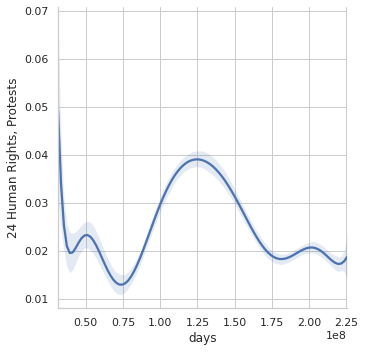

In [98]:
data = df.loc[df["position"] == "regime"]
sns.lmplot(data = data, x= "days", order = 11,
           y= "24 Human Rights, Protests",
          scatter = False)

<AxesSubplot:xlabel='quarter', ylabel='24 Human Rights, Protests'>

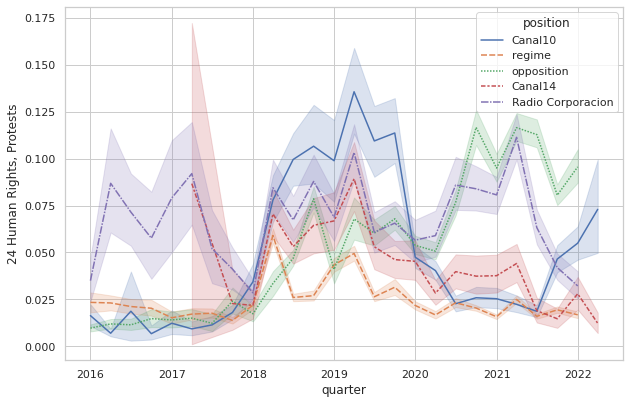

In [57]:
(df
 .pipe((sns.lineplot, "data"),
       x= df.index, y="24 Human Rights, Protests",
       estimator = np.mean,
       style="position", hue="position"))

<AxesSubplot:xlabel='date', ylabel='average'>

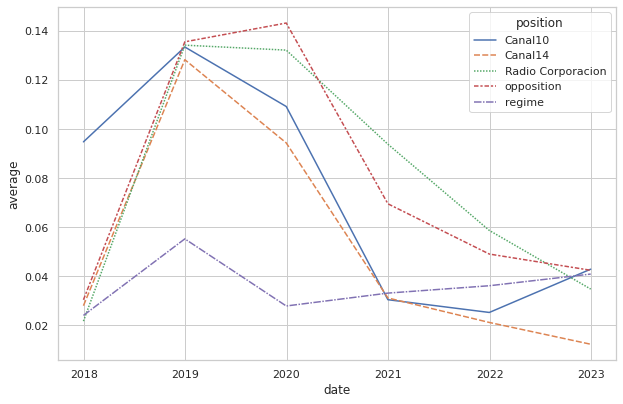

In [245]:
# create aggregated overview of sentiment per position and year-quarter
df_agg = (df.loc[df["date"] > "2017"]
          .groupby(["position",pd.Grouper(key='date', freq='Y')])['13 Police, Detentions, Protests']
          .agg(average = np.mean)
          .reset_index())

(df_agg
 .pipe((sns.lineplot, "data"),
       x="date", y="average",
       style="position", hue="position"))

## Create independence score

In [308]:
df_agg = (df.loc[df["date"] > "2017"]
          .groupby(["position",pd.Grouper(key='date', freq='Y')])
          .agg("mean")
          .reset_index())

In [273]:
relevant_cols = ['1 Corona Cases',
 '3 Victims (of accidents)',
 '5 Foreign Relations',
 '11 Business, Public Projects',
 '12 Legal Cases (against opposition)',
 '13 Police, Detentions, Protests',
 '14 Vaccines',
 '17 Elections, Parties',
 '19 Welfare, State-Citizen Interactions',
 '21 Press and Censorship',
 '24 Human Rights, Protests',
 '27 Conflict with OAS']

In [274]:
import math

## Independence Scores without weights or NANs

<AxesSubplot:xlabel='date', ylabel='independence score'>

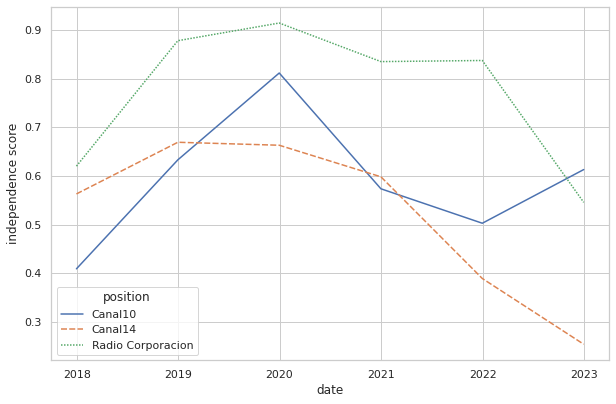

In [309]:
# create separate wide df for each topic
topic_dfs = {}
for x in relevant_cols:
    dfx = pd.pivot(df_agg,
                   index = "date",
                   columns = "position",
                   values = x)
# calculate independence score for in each df
    dfx["canal10_ind"] = ((dfx["Canal10"]-dfx["regime"])/(dfx["opposition"]-dfx["regime"])).clip(0, 1)
    dfx["canal14_ind"] = ((dfx["Canal14"]-dfx["regime"])/(dfx["opposition"]-dfx["regime"])).clip(0, 1)
    dfx["Radio Corporacion_ind"] = ((dfx["Radio Corporacion"]-dfx["regime"])/(dfx["opposition"]-dfx["regime"])).clip(0, 1)
    
# save in dictionary
    topic_dfs.update({x:dfx})

# put independence scores per topic back into one long-format df

df_ind = df_agg[df_agg["position"].isin(["Canal10", "Canal14", "Radio Corporacion"])][["position", "date"]]

for x in relevant_cols:
    df_ind[x] = pd.melt(topic_dfs[x].reset_index(),
                        id_vars=['date'],
                        value_vars=['canal10_ind', "canal14_ind", "Radio Corporacion_ind"],
                        value_name = "independence score")["independence score"]
# bring into long format
df_ind = pd.melt(df_ind,
        id_vars=["position", 'date'],
        value_vars=relevant_cols,
        value_name = "independence score",
        var_name = "topic")

# aggregate per outlet
df_final = df_ind.groupby(["position", "date"]).agg("mean") .reset_index()

(df_final
 .pipe((sns.lineplot, "data"),
       x="date", y="independence score",
       style="position", hue="position"))

## Independence scores with NAN

<AxesSubplot:xlabel='date', ylabel='independence score'>

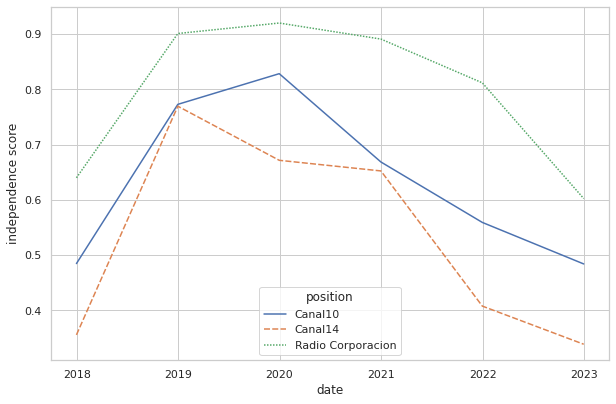

In [310]:
# create separate wide df for each topic
topic_dfs = {}
for x in relevant_cols:
    dfx = pd.pivot(df_agg,
                   index = "date",
                   columns = "position",
                   values = x)
# calculate independence score for in each df
    dfx["canal10_ind"] = ((dfx["Canal10"]-dfx["regime"])/(dfx["opposition"]-dfx["regime"])).clip(0, 1)
    dfx["canal14_ind"] = ((dfx["Canal14"]-dfx["regime"])/(dfx["opposition"]-dfx["regime"])).clip(0, 1)
    dfx["Radio Corporacion_ind"] = ((dfx["Radio Corporacion"]-dfx["regime"])/(dfx["opposition"]-dfx["regime"])).clip(0, 1)

# make independence scores NA if there is no substantive difference between regime and opposition
# the idea is that independence can only exist if the topic is relevant at the time to regime legitimation
# e.g. corona did not exist in 2018, so difference in the topic in that year should not factor into the
# calculation of the independence of an outlet for that year

    dfx["canal10_ind"] = dfx["canal10_ind"].where(((dfx["regime"]-dfx["opposition"])**2)**0.5 > 0.015 , np.nan)
    dfx["canal14_ind"] = dfx["canal14_ind"].where(((dfx["regime"]-dfx["opposition"])**2)**0.5 > 0.015 , np.nan)
    dfx["Radio Corporacion_ind"] = dfx["Radio Corporacion_ind"].where(((dfx["regime"]-dfx["opposition"])**2)**0.5 > 0.015 , np.nan)
    
# save in dictionary
    topic_dfs.update({x:dfx})

# put independence scores per topic back into one long-format df

df_ind = df_agg[df_agg["position"].isin(["Canal10", "Canal14", "Radio Corporacion"])][["position", "date"]]

for x in relevant_cols:
    df_ind[x] = pd.melt(topic_dfs[x].reset_index(),
                        id_vars=['date'],
                        value_vars=['canal10_ind', "canal14_ind", "Radio Corporacion_ind"],
                        value_name = "independence score")["independence score"]
# bring into long format
df_ind = pd.melt(df_ind,
        id_vars=["position", 'date'],
        value_vars=relevant_cols,
        value_name = "independence score",
        var_name = "topic")

# aggregate per outlet
df_final = df_ind.groupby(["position", "date"]).agg("mean") .reset_index()

(df_final
 .pipe((sns.lineplot, "data"),
       x="date", y="independence score",
       style="position", hue="position"))

## alternative with weights instead of NAN

<AxesSubplot:xlabel='date', ylabel='independence score'>

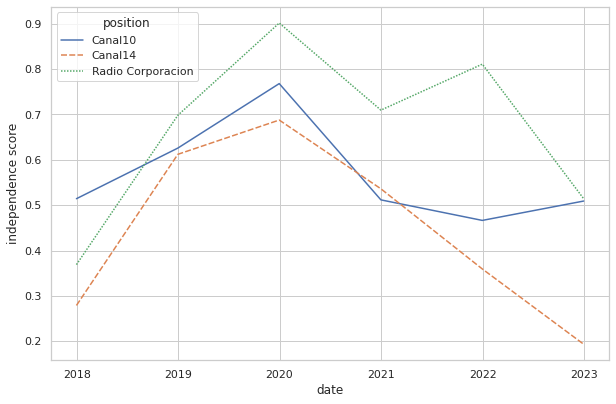

In [311]:
# create separate wide df for each topic
topic_dfs = {}
for x in relevant_cols:
    dfx = pd.pivot(df_agg,
                   index = "date",
                   columns = "position",
                   values = x)
# calculate independence score for in each df
    dfx["canal10_ind"] = ((dfx["Canal10"]-dfx["regime"])/(dfx["opposition"]-dfx["regime"])).clip(0, 1)
    dfx["canal14_ind"] = ((dfx["Canal14"]-dfx["regime"])/(dfx["opposition"]-dfx["regime"])).clip(0, 1)
    dfx["Radio Corporacion_ind"] = ((dfx["Radio Corporacion"]-dfx["regime"])/(dfx["opposition"]-dfx["regime"])).clip(0, 1)

# create weight variable, so that it is 1 when there is a .1 difference in topic prevalence between regime
# and opposition. That is about as distant as it gets.

    dfx["weight"] = ((dfx["regime"]-dfx["opposition"])**2)**0.5
    dfx["weight"].where(dfx["weight"] > 0.013 , np.nan, inplace = True)
    dfx["weight"] = dfx["weight"]*20

# applying weights to independence scores
    dfx["canal10_ind"] = dfx["canal10_ind"]*dfx["weight"]
    dfx["canal14_ind"] = dfx["canal14_ind"]*dfx["weight"]
    dfx["Radio Corporacion_ind"] = dfx["Radio Corporacion_ind"]*dfx["weight"]
    
# save in dictionary
    topic_dfs.update({x:dfx})

# put independence scores per topic back into one long-format df

df_ind = df_agg[df_agg["position"].isin(["Canal10", "Canal14", "Radio Corporacion"])][["position", "date"]]

for x in relevant_cols:
    df_ind[x] = pd.melt(topic_dfs[x].reset_index(),
                        id_vars=['date'],
                        value_vars=['canal10_ind', "canal14_ind", "Radio Corporacion_ind"],
                        value_name = "independence score")["independence score"]
# bring into long format
df_ind = pd.melt(df_ind,
        id_vars=["position", 'date'],
        value_vars=relevant_cols,
        value_name = "independence score",
        var_name = "topic")

# aggregate per outlet
df_final = df_ind.groupby(["position", "date"]).agg("mean") .reset_index()

(df_final
 .pipe((sns.lineplot, "data"),
       x="date", y="independence score",
       style="position", hue="position"))